## Introduction and restatement of requirements

A journalist who wants to write an article about SNL has given us CSV files containing data from the show Saturday Night Live. The CSV files provided have data on episodes, seasons, segments, appearances, and actors. 

Our goal is to analyze the SNL data and create a dashboard that shows the five actors that appeared the most times on the show (in total, as a cast member, and as a host), the ratio of female to male appearances over time (in total, as a cast member, and as a host), and how the number of segments per episode has changed over time. Additionally, we must find how many segments contained Former President Trump's name over time.

In order to achieve our goal, we need to create staging tables (along with concrete examples, a conceptual ER diagram, and a physical ER diagram), and write and execute statements to create and load data into the staging tables. From there, we need to convert our staging tables into a star schema, identify the facts and grain of our data, and create a transformation diagram. Afterward, we create concrete examples, a conceptual and physical ER diagram, and the star schema by writing dbt model files. Next, we create data products that answer the required questions, write the dbt model files for the data products, and answer the questions using tables and charts.






## Data Ingestion

### Documentation for source data

**Examples of Concrete data**

![image.png](img/source_data.png)

**Conceptual ER**
![image.png](img/staging_table/conceptual_er.png)


**Physical ER**

![image.png](img/staging_table/physical_er.png)

**Sample tables**
![image.png](img/staging_table/sample_table.png)

### SQL to create staging tables

```sql
DROP TABLE IF EXISTS staging.actors;
DROP TABLE IF EXISTS staging.appearances;
DROP TABLE IF EXISTS staging.episodes;
DROP TABLE IF EXISTS staging.seasons;
DROP TABLE IF EXISTS staging.segments;

CREATE TABLE IF NOT EXISTS staging.actors (
  actor_id INTEGER PRIMARY KEY,
  actor_name TEXT,
  gender TEXT
);

CREATE TABLE IF NOT EXISTS staging.appearances (
  appearance_id INTEGER PRIMARY KEY,
  actor_id INTEGER,
  role TEXT,
  capacity TEXT,
  is_voice_role BOOLEAN,
  segment_id INTEGER
);

CREATE TABLE IF NOT EXISTS staging.episodes (
  episode_id INTEGER PRIMARY KEY,
  aired_at TEXT,
  season_id INTEGER,
  episode_order_in_season INTEGER
);

CREATE TABLE IF NOT EXISTS staging.seasons (
  season_id INTEGER PRIMARY KEY,
  year INTEGER,
  first_episode_id INTEGER,
  last_episode_id INTEGER,
  num_episode_in_season INTEGER
);

CREATE TABLE IF NOT EXISTS staging.segments (
  segment_id INTEGER PRIMARY KEY,
  name TEXT,
  category TEXT,
  episode_id INTEGER,
  segment_order_in_episode INTEGER
);
```

We ran these scripts by typing ```bash create_staging_tables.sh``` in a terminal in the directory ```i320d/projects/snl/src/scripts```

### Load script with \copy commands


**\copy Commands File Content**
```sql
TRUNCATE TABLE actors;
TRUNCATE TABLE appearances;
TRUNCATE TABLE episodes;
TRUNCATE TABLE seasons;
TRUNCATE TABLE segments;


\copy actors  FROM '../../data/actors.csv' WITH HEADER CSV;
\copy appearances  FROM '../../data/appearances.csv' WITH HEADER CSV;
\copy episodes  FROM '../../data/episodes.csv' WITH HEADER CSV;
\copy seasons  FROM '../../data/seasons.csv' WITH HEADER CSV;
\copy segments  FROM '../../data/segments.csv' WITH HEADER CSV;
```

This file is located in the ```i320d/projects/snl/src/scripts/``` directory and is named ```copy_staging_data.sql```. The image below displays where the file is found on JupyterLab. By running ```bash load_staging_data.sh``` in the JupyterLab kernel when we are in the ```i320d/projects/snl/src/scripts/``` directory, the tables are loaded with the necessary information from our csv files. 

```copy_staging_data.sql``` **file location**

![image.png](img/staging_table/copy_staging.png)

## Data Transformation

### Transformation to Star Schema

#### Identify facts, grain, and dimensions

Discuss your data to identify, with reference to the project requirements, the relevant facts, grain and dimensions.  Approx 1-2 paragraphs.

For our project, we need to identify the actors who appeared in the most episodes of the show (in general, as a cast member, and as a host), the female-to-male ratio overtime (in general, as a cast member, and as a host), the number of segments per episode, and how many times Trump's name was in a segment name overtime. We realized that the female-to-male ratio and the actor appearances question had columns that overlapped with one another, so we made the appearance table our fact table. After that, although not additive, we added the gender column from the actor staging table to the fact table to help us answer the second question. 

For our grain, we decided that each row in our fact table would represent an actor's appearance in a specific segment of an episode within a season. The star schema will contain four dimensions: the actor dimension, appearance dimension, season dimension, and episode dimension. We dropped any unnecessary columns from the dimensions. For the episode dimension, we created a column called num_segments_in_episode that will help us answer the third question.

#### Transformation diagram

![image.png](img/transformational_diagram/transformational_model.png)

#### Documentation for star schema

**Examples of Concrete data (for the star schema)**
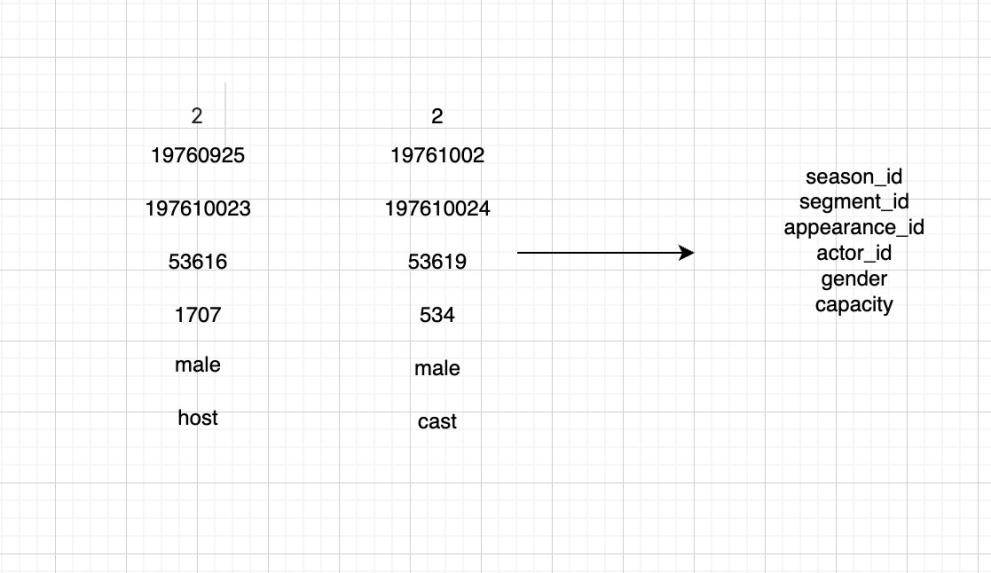

**Conceptual ER (for the star schema)**
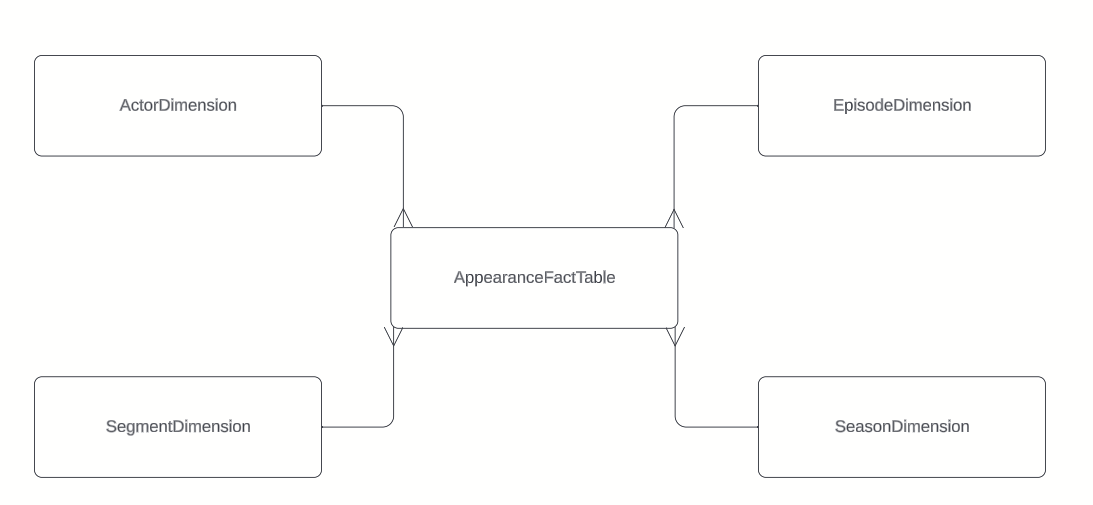

**Transformation Table (for the star schema)**
![image.png](img/transformational_diagram/td.png)

**Physical ER (for the star schema)**
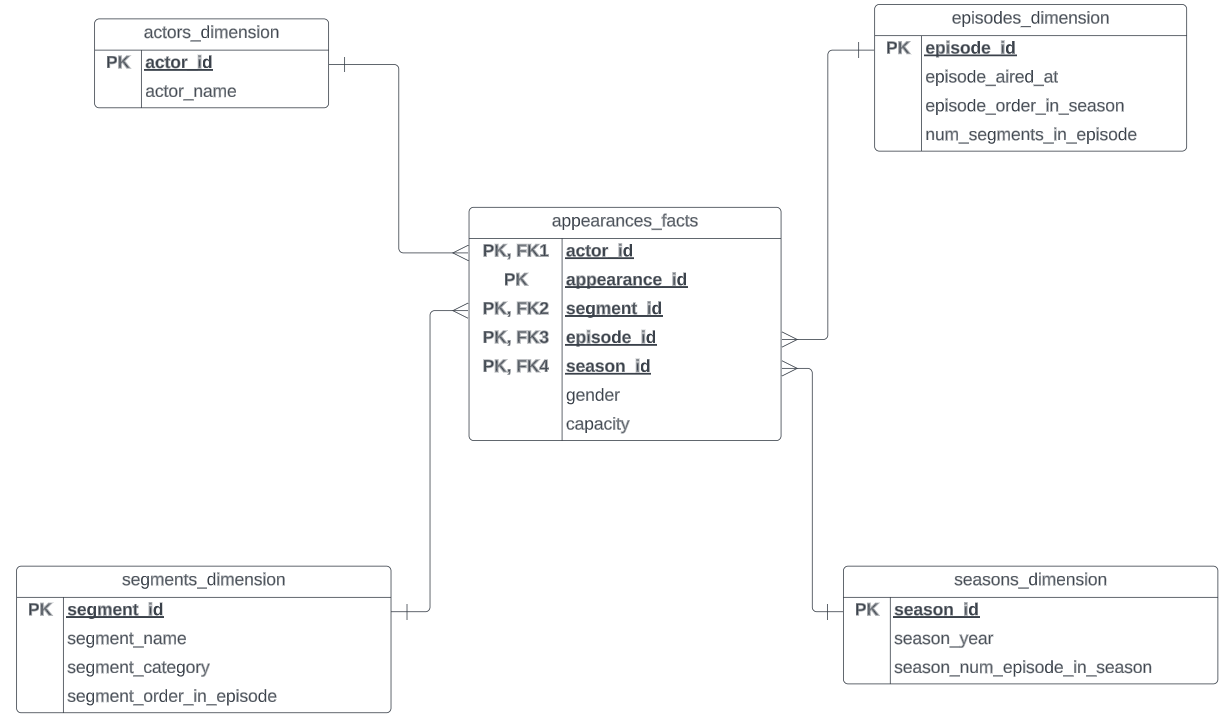

**Sample tables (screenshots are sufficient)**
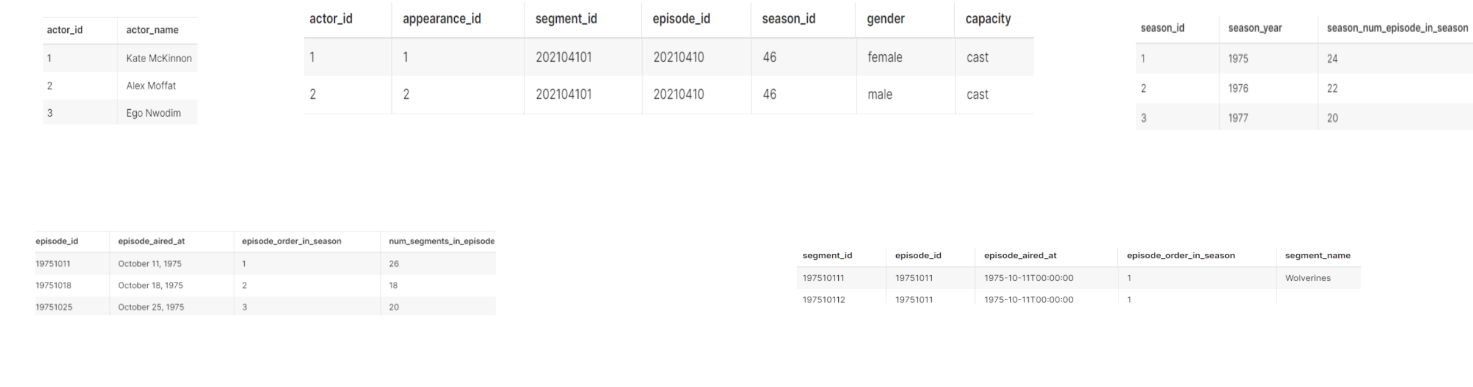

#### dbt models transforming to star schema

```appearances_facts.sql```
```sql
{{ config(
    materialized="table"
) }}


SELECT  actor_id, 
        appearance_id,
        segment_id,
        episode_id,
        season_id,
        gender,
        capacity
        
FROM staging.appearances
JOIN staging.actors USING (actor_id)
JOIN staging.segments USING (segment_id )
JOIN staging.episodes USING (episode_id )
JOIN staging.seasons USING (season_id)


```

```actors_dimension.sql```
```sql
{{ config(
    materialized="table"
) }}

SELECT actor_id,
       actor_name
FROM   staging.actors
```

```episodes_dimension.sql```
```sql
{{ config(
    materialized="table"
) }}

SELECT episode_id,
       aired_at AS episode_aired_at,
       episode_order_in_season, 
       COUNT (DISTINCT segment_id ) AS num_segments_in_episode
FROM   staging.episodes
JOIN   staging.segments USING (episode_id)
GROUP  BY episode_id
```

```seasons_dimension.sql```
```sql
{{ config(
    materialized="table"
) }}
SELECT season_id,
       year AS season_year,
       num_episode_in_season AS season_num_episode_in_season
FROM   staging.seasons
```

```segments_dimension.sql```
```sql
{{ config(
    materialized="table"
) }}
SELECT segment_id,
       name AS segment_name,
       category AS segment_category,
       segment_order_in_episode
FROM   staging.segments

```

### Transformation to Data Products

#### Rationale for data products produced

- We chose to make ```actor_data_product.sql``` because it allowed us to answer two questions with one data product due to the similar nature of the first and second required questions. Both questions deal with capacity while also needing the episode_id and actor_id. 

- We chose to make ```segment_data_product.sql``` to answer the required third and fourth question. Both questions involved the segments dimension and we did not need to join too many tables to get the necessary data to answer both.

#### dbt model files to create and load the data into your data product(s)

```actor_data_product.sql```
```sql

{{ 
   config(  
     materialized="table"  
   ) 
}}

SELECT af.gender, 
       af.capacity, 
       DATE(season_year || '-01-01') AS season_year,
       ad.actor_name,
       ed.episode_id
       
FROM appearances_facts AS af
JOIN {{ref("actors_dimension")}} AS ad USING (actor_id) 
JOIN {{ref("seasons_dimension")}} AS sea USING (season_id) 
JOIN {{ref("episodes_dimension")}} AS ed USING (episode_id) 
```

```segment_data_product.sql```
```sql


{{ 
   config(  
     materialized="table"  
   ) 
}}

SELECT
  DISTINCT segment_id,
  episode_id,
  CAST(episode_aired_at AS TIMESTAMP) AS episode_aired_at,
  episode_order_in_season,
  segment_name,
  segment_category,
  DATE(season_year || '-01-01') AS season_year,
  season_num_episode_in_season,
  num_segments_in_episode
FROM
  appearances_facts AS af
  JOIN {{ref("episodes_dimension")}} AS ed USING (episode_id)
  JOIN {{ref("segments_dimension")}} AS sed USING (segment_id)
  JOIN {{ref("seasons_dimension")}} AS sea USING (season_id)
 ```

## Data Analysis and Visualization

### Addressing project requirements

1. We found that the people who appeared in the most episodes of SNL (in descending order by number of appearances) were Darrell Hammond, Steve Higgens, Kenan Thompson, Seth Meyers, and Fred Armisen. The values range from mid 200s to low 400s. The same five people (in the same order) also appeared in the most episodes as cast members; however, none appear in the top five people who appeared in the most episodes as a host. There aren't many differences in the top five's values compared to their number of appearances overall. The top 5 people who have appeared as hosts are (in descending order by number of appearances) Alec Baldwin, Steve Martin, John Goodman, Buck Henry, and Tom Hanks; all hosts have less than twenty appearances as hosts.

2. The ratio of female to male cast appearances over time has a concave-up shape. The early 1990s saw the ratio at its lowest, but it has generally been going upward since then. When looking at the ratio for just cast members, the highest the ratio went was in 2016 with about eighty percent; sadly, since then, it appears to be going down. It still has a concave-up-like shape. On the other hand, the host ratios look completely different: there are many peaks. In 2000, the ratio became 120%. It has a pattern of peaks and valleys.

3. We found that the amount of segments per episode has decreased in the twenty-first century compared to SNL's beginnings (which had many appearances around the mid to low twenties). Episodes in the twenty-first century usually contain about fourteen segments. Overall, the number of segments per episode has generally decreased over the years. Like the female-to-male ratio for hosts, there are a decent amount of peaks and valleys dispersed throughout.

4. We found that Trump's name appeared most frequently in segment names in 2015, 2016, and 2018. Trump’s name appeared in six segment names in both 2015 and 2016. In 2018, his name appeared in five segment names. In 2019, 2017, 2006, 2004, and 2003, his name was in two segment names; finally, in 2020 and 1999, his name was in only one segment name.

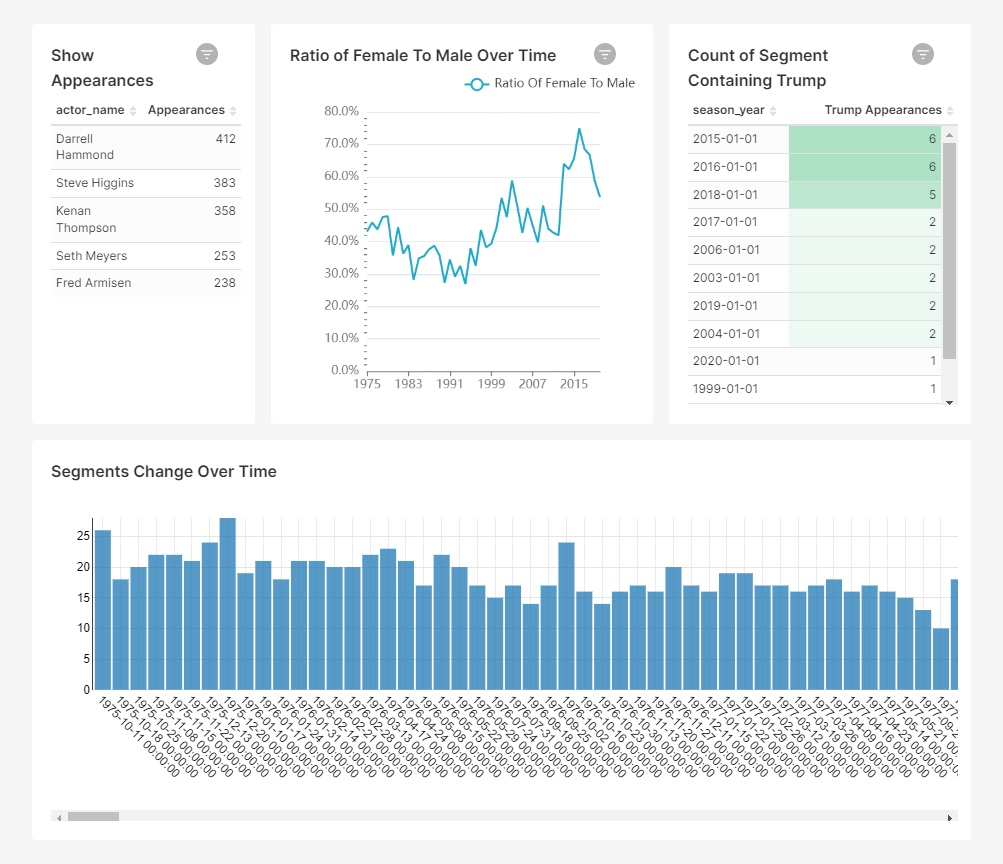


**Link to the dashboard:** https://superset.dei320.net/superset/dashboard/p/kWxGggQWG8v/

## Document your visualization decisions

- To find the actors who have appeared the most times in total as a cast member or as a host, we visualized our findings via a table. Because the actors' names are categorical, the table allows people to compare the different numbers' appearances quickly. 

- To see how the ratio of actresses and actors changed over time, we utilized a line chart. We decided to use a line chart because it clearly shows trends and changes over time.

For the actors' appearances and the ratio of actresses to actors, we decided to create a capacity filter so the user could interact with the visualizations to get the information that they want and so we minimalize the number of visualizations.

- To find how the number of segments per episode changed over time, we used a bar graph. We chose a bar graph because it allows people to see the changes over time.

- To see how many times Trump's name appeared in the segment name, we used a table again. Because there aren't many data points, a table allows people to view and compare throughout the years. We utilized darker shades of red to emphasize that his name appeared more frequently than in other years.



## Document your visualization decisions

## Reflection and challenges addressed

We initially needed help determining how many data products we needed. The first two questions we were trying to answer were formatted very similarly, so we utilized one data product to answer the first two questions. 

Another issue we faced was visualizing the female-to-male ratio over time. We did not want to perform ```GROUP BY``` queries in our data product because we were using the same data product to create visualizations for another question. Thanks to the guidance of Professor Young and Urjani, we were able to utilize the ```COALESCE``` and ```GREATEST```functions to get the female-to-male cast appearance ratio without using ```GROUP BY```.

We were really proud that we could find a solution to the ratio issue without complicating our data product. Additionally, we were also proud that we solved the segment number overtime question. At first, our bar chart only had one value, and line charts did not work. We eventually found that we should sort our data by ```episode_id``` rather than ```segment_id```. 

We were proud that we could limit the amount of tables we had. Questions 1 and 2 require us to find the amount of show appearances in total, as a cast member, and as a host. Using a filter, we only needed to create one table and one chart instead of six separate visualizations.




